# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [3]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [34]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        hidden_layer_width = 128

        self.mlp_stack = nn.Sequential()
        self.mlp_stack.append(nn.Linear(no_features, hidden_layer_width))
        for _ in range(no_hidden):
            self.mlp_stack.append(nn.Linear(hidden_layer_width, hidden_layer_width))
            self.mlp_stack.append(nn.ReLU())
            self.mlp_stack.append(nn.Dropout(0.2))
        self.mlp_stack.append(nn.Linear(hidden_layer_width, no_labels))
        self.mlp_stack.append(nn.Sigmoid())

    # YOUR CODE HERE
    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [35]:
from common_utils import split_dataset, preprocess_dataset

random_seed = 0

def preprocess(df):
    # YOUR CODE HERE
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, random_seed)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print(df['label'].value_counts())

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

label
pos    6202
neg    5855
Name: count, dtype: int64


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [36]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)

        self.features = torch.tensor(features, dtype=torch.float32)
        # model output shape is (X, 1), so we need to reshape our labels from 1D to 2D
        self.labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1) 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        label = self.labels[idx]
        features = self.features[idx]

        return features, label

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    train_data = CustomDataset(X_train_scaled, y_train)
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)

    test_data = CustomDataset(X_test_scaled, y_test)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [37]:
model = MLP(77, 3, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [38]:
model

MLP(
  (mlp_stack): Sequential(
    (0): Linear(in_features=77, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=128, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [39]:
from common_utils import EarlyStopper

num_epochs = 100

losses_train = []
losses_test = []

accuracies_train = []
accuracies_test = []

early_stopper = EarlyStopper(patience=3)

for i in range(num_epochs):
    # prepare model for training
    model.train()
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

    model.eval() # prepare model for evaluation
    with torch.no_grad():
        overall_loss = []
        overall_accuracy = []

        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch)

            accuracy = (y_pred.round() == y_batch).float().mean()
            accuracy = float(accuracy)
            overall_accuracy.append(accuracy)

            loss = loss_fn(y_pred, y_batch)
            overall_loss.append(loss.detach().numpy())

        losses_train.append(sum(overall_loss) / len(overall_loss))
        accuracies_train.append(sum(overall_accuracy) / len(overall_accuracy))

        overall_loss = []
        overall_accuracy = []

        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)

            accuracy = (y_pred.round() == y_batch).float().mean()
            accuracy = float(accuracy)
            overall_accuracy.append(accuracy)

            loss = loss_fn(y_pred, y_batch)
            overall_loss.append(loss.detach().numpy())

        losses_test.append(sum(overall_loss) / len(overall_loss))
        accuracies_test.append(sum(overall_accuracy) / len(overall_accuracy))

    if i % 10 == 0:
        print(f"Epoch {i}, Training loss: {losses_train[-1]}, Training acc: {accuracies_train[-1]}, Test loss: {losses_test[-1]}, Test acc: {accuracies_test[-1]}")

    if early_stopper.early_stop(losses_test[-1]):
        print(f"Early stop at epoch {i}")
        break

Epoch 0, Training loss: 0.6740115917090214, Training acc: 0.5788558342240073, Test loss: 0.6757240056991577, Test acc: 0.5761029402414958
Epoch 10, Training loss: 0.46032033093047864, Training acc: 0.7843185464541117, Test loss: 0.5756748914718628, Test acc: 0.7083792885144552
Epoch 20, Training loss: 0.3006520542231473, Training acc: 0.8814069014607053, Test loss: 0.5555433233579, Test acc: 0.7369025746981303
Early stop at epoch 27


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


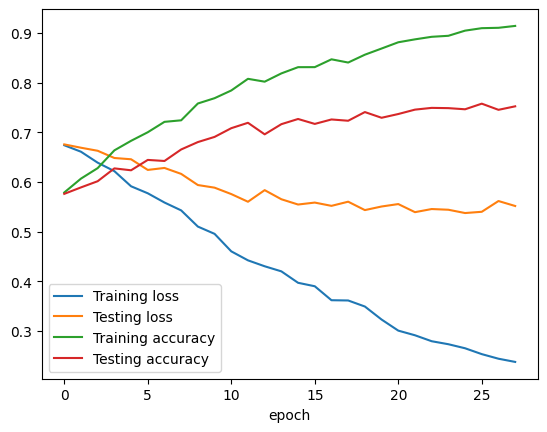

In [41]:
# YOUR CODE HERE
plt.plot(losses_train, label="Training loss")
plt.plot(losses_test, label="Testing loss")
plt.plot(accuracies_train, label="Training accuracy")
plt.plot(accuracies_test, label="Testing accuracy")

plt.xlabel("epoch")
plt.legend()

2. Comment on line plots.

- The model quickly overfits, as shown in the plots. The training loss goes down, but the validation loss goes back up instead (which is a sign of overfitting)